In [1]:
import numpy as np
from numpy import genfromtxt
from rocketpy import Function
from data import *
from control.matlab import *
from ipywidgets import interact, widgets
plt.style.use('seaborn')

## Calculo de propriedades

In [2]:
class Canard:
    def __init__(self, n, span, rootChord, tipChord, radius, airfoil):
        self.n = n
        self.span = span
        self.rootChord = rootChord
        self.tipChord = tipChord
        self.radius = radius
        self.airfoil = airfoil
        
        self.area = np.pi * radius**2
        self.addFins()

    def addFins(self):
        # Retrieve parameters for calculations
        Af = (self.rootChord + self.tipChord) * self.span / 2  # fin area
        AR = 2 * (self.span ** 2) / Af  # Aspeself.tipChord ratio
        gamac = np.arctan((self.rootChord - self.tipChord) / (2 * self.span))  # mid chord angle

        # Import the lift curve as a funself.tipChordion of lift values by attack angle
        read = genfromtxt(self.airfoil, delimiter=",")
        cnalfa0 = Function(read, extrapolation="natural").differentiate(0, 1e-01)

        # Calculate clalpha
        FD = 2 * np.pi * AR / (cnalfa0 * np.cos(gamac))
        clalpha = (
            cnalfa0
            * FD
            * (Af / self.area)
            * np.cos(gamac)
            / (2 + FD * (1 + (4 / FD ** 2)) ** 0.5)
        )

        # Aplies number of fins to lift coefficient
        clalpha *= self.n / 2

        # Fin–body interference correself.tipChordion
        clalpha *= 1 + self.radius / (self.span + self.radius)

        # self.rootChordeate a funself.tipChordion of lift values by attack angle
        cldata = Function(
            lambda x: clalpha * x, "Alpha (rad)", "Lift coeficient (Cl)", interpolation="linear"
        )

        # Save cldata
        self.cldata = cldata

        # Calculate roll forcing properties
        Ymac = self.radius + self.span / 3 * (self.rootChord + 2 * self.tipChord) / (self.rootChord + self.tipChord)
        clf_delta = clalpha * Ymac / (2 * self.radius)

        clfdata = Function(
            lambda delta: clf_delta * delta, "Delta (rad)", "Roll forcing coeficient (Clf)", interpolation="linear"
        )

        # Save clfdata
        self.clfdata = clfdata

        # Calculate roll damping properties
        b1 = (Ymac /  2) * (self.radius**2) * self.span
        b2 = ((self.rootChord + 2 * self.tipChord) / 3) * self.radius * (self.span**2)
        b3 = ((self.rootChord + 3 * self.tipChord) / 12) * (self.span**3)
        trapezoidal_constant_fins = b1 + b2 + b3

        cld_wv = self.n * cnalfa0 * trapezoidal_constant_fins / (self.area * 2 * self.radius)
        self.cld_data = lambda w, v: cld_wv * w / v

## Definindo aletas e canards

In [3]:
'''Dados do Mini'''
# Dados das aletas
n = 3
span = 0.077
rootChord = 0.058
tipChord = 0.018
airfoil = 'NACA0012 curva Completa.txt'
angulo_maximo_de_abertura = 3 * np.pi / 180

# Dados das canards
n_canard = 2
span_canard = 0.06
rootChord_canard = 0.035
tipChord_canard = 0.035
airfoil_canard = 'NACA0012 curva Completa.txt'
angulo_maximo_de_abertura_canard = 7 * np.pi / 180

# Dados do foguete
radius = 80.9/2000
J = 0.007
Ar = np.pi * radius**2 # Área de referencia
Lr = 2 * radius # Comprimento de referencia

# Dados do ambiente ao redor
rho = 1.06 # air density
velocidade = 0.3 * 343 # Mach 0.5
DynamicPressure = velocidade**2 * rho / 2

# Criando objeto correspondente à aleta
aleta = Canard(n, span, rootChord, tipChord, radius, airfoil)
canard = Canard(n_canard, span_canard, rootChord_canard, tipChord_canard, radius, airfoil)

In [4]:
'''Dados do Europa'''
# # Dados das aletas
# n = 4
# span = 100 / 1000
# rootChord = 120 / 1000
# tipChord = 40 / 1000
# airfoil = 'NACA0012 curva Completa.txt'
# angulo_maximo_de_abertura = 2 * np.pi / 180

# # Dados das canards
# n_canard = 4
# span_canard = 80 / 1000
# rootChord_canard = 40 / 1000
# tipChord_canard = 40 / 1000
# airfoil_canard = 'NACA0012 curva Completa.txt'
# angulo_maximo_de_abertura_canard = 7 * np.pi / 180

# # Dados do foguete
# radius = 127/2000
# J = 0.007
# Ar = np.pi * radius**2 # Área de referencia
# Lr = 2 * radius # Comprimento de referencia

# # Dados do ambiente ao redor
# rho = 1.06 # air density
# velocidade = 0.7 * 343 # Mach 0.5
# DynamicPressure = velocidade**2 * rho / 2

# # Criando objeto correspondente à aleta
# aleta = Canard(n, span, rootChord, tipChord, radius, airfoil)
# canard = Canard(n_canard, span_canard, rootChord_canard, tipChord_canard, radius, airfoil)

'Dados do Europa'

## Criando as funções de transferência

In [5]:
# Parametros das aletas
forcing_aletas_coef = aleta.clfdata.differentiate(0)
damping_aletas_coef = aleta.cld_data(1, velocidade) - aleta.cld_data(0, velocidade)

# Parametros das canards
forcing_canard_coef = canard.clfdata.differentiate(0)
damping_canard_coef = canard.cld_data(1, velocidade) - canard.cld_data(0, velocidade)

# Parametros intermediarios
P = DynamicPressure * Ar * Lr
C = (damping_aletas_coef + damping_canard_coef)

s = tf([1, 0], 1)

# Planta
Gp = 1 / (J * s + P * C)

# Servo
tau_s = 0.07 / (np.pi/3)
Gs = 1 / (tau_s * s + 1)

# Controlador
Kp = 0.015
I = 7e-3 * 100 * 3
D = 0

print('Kp =', Kp)
print('Ki =', Kp * I)
print('Kd =', Kp * D)

Gc = Kp * (1 + I / s + D * s) # Root Locus do ganho proporcional

# Sensoreamento
H = 1

# Função de transferência total
G = feedback(Gc * Gs * Gp * forcing_canard_coef, H)
print('Ganho da planta = {:.2f} (rad/s) / (N.m)'.format(1 / ((damping_aletas_coef + damping_canard_coef) * DynamicPressure * Ar * Lr)) )
print('Constante de tempo da planta = {:.3f}s'.format(J / ((damping_aletas_coef + damping_canard_coef) * DynamicPressure * Ar * Lr)))
G

Kp = 0.015
Ki = 0.0315
Kd = 0.0
Ganho da planta = 40.86 (rad/s) / (N.m)
Constante de tempo da planta = 0.286s


TransferFunction(array([0.02707, 0.05685]), array([0.00047, 0.00864, 0.05154, 0.05685]))

### Mapa de Polos e Zeros

(array([-8.52239+3.66966j, -8.52239-3.66966j, -1.41103+0.j     ]),
 array([-2.1]))

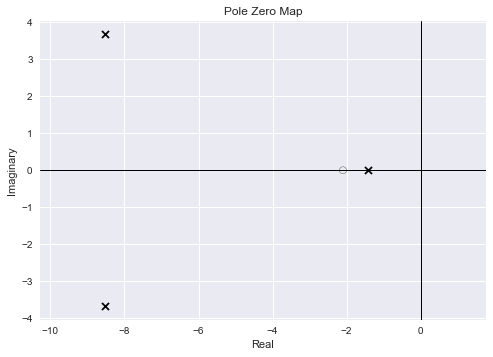

In [6]:
pzmap(G)

### Resposta à uma entrada impulso

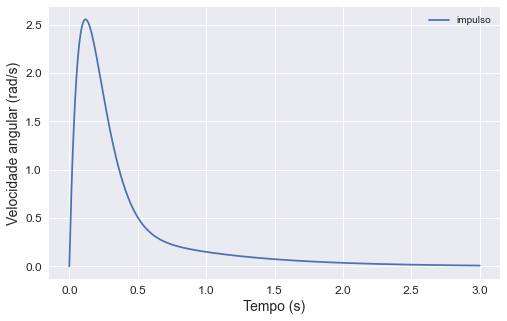

In [7]:
yi, xi = impulse(G)
fi = Data(xi, yi, 'Tempo (s)', 'Velocidade angular (rad/s)', 'impulso', method='cubicSpline')
fi.plot2D(style='matplotlib', upper=3)

### Resposta à uma entrada degrau

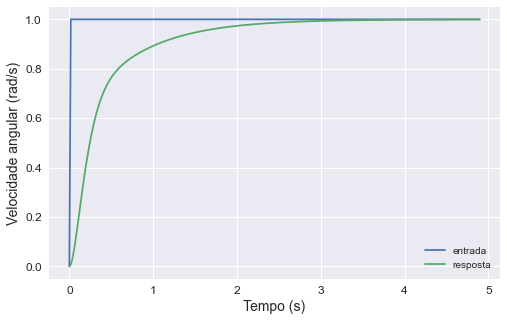

{'RiseTime': 0.9726259672849977,
 'SettlingTime': 2.2046188591793285,
 'SettlingMin': 0.9004417122247337,
 'SettlingMax': 0.999558900567329,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 0.999558900567329,
 'PeakTime': 4.895550702001156,
 'SteadyStateValue': 1.0}

In [8]:
# ts = np.linspace(0, 3, 1001)
ys, xs = step(G)
fs = Data(xs, ys, 'Tempo (s)', 'Velocidade angular (rad/s)', 'resposta', method='cubicSpline')
fin = Data(xs, [0 if i == 0 else 1 for i in range(len(xs))], 'Tempo (s)', 'Velocidade angular (rad/s)', 'entrada')
fin.compara2Plots(fs, style='matplotlib')
# fs.plot2D(style='matplotlib')
stepinfo(G)

### Resposta à uma entrada rampa

C:\Users\bruno\anaconda3\lib\site-packages\control\timeresp.py:293: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


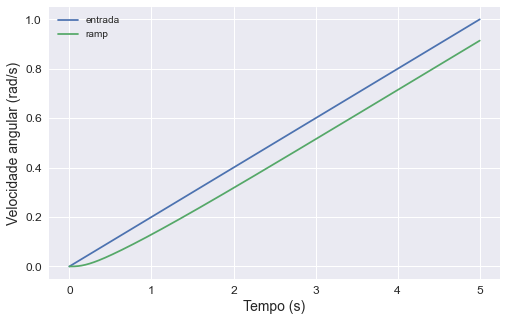

In [9]:
t = np.linspace(0, 5, 1001)
ramp = np.array([t[i] / max(t) for i in range(len(t))])
yr = lsim(G, ramp, t)[0]
fin = Data(t, ramp, 'Tempo (s)', 'Velocidade angular (rad/s)', 'entrada')
fr = Data(t, yr, 'Tempo (s)', 'Velocidade angular (rad/s)', 'ramp', method='cubicSpline')
fin.compara2Plots(fr, style='matplotlib')

## Bode

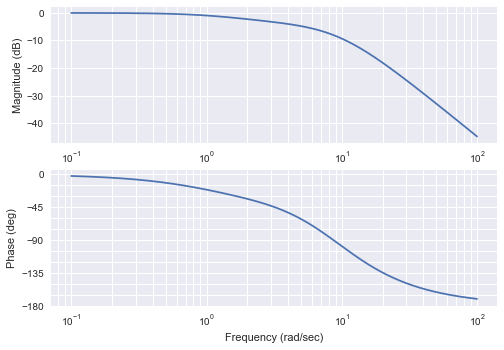

In [10]:
mag, phase, omega = bode(G)

## Root Locus

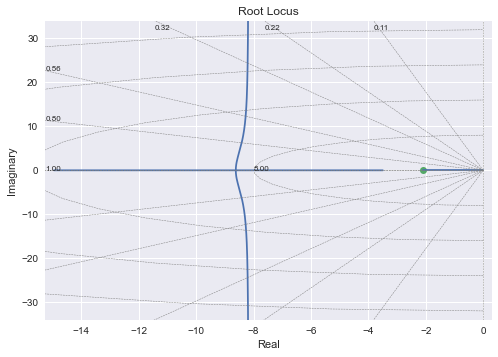

In [11]:
Gr = Gc * Gs * Gp * forcing_canard_coef / Kp
_ = rlocus(Gr)

## Interact

In [12]:
def interect_PID(Kp, Ki, Kd):
    s = tf([1, 0], 1)

    # Planta
    Gp = 1 / (J * s + P * C)

    # Servo
    tau_s = 0.07 / (np.pi/3)
    Gs = 1 / (tau_s * s + 1)

    # Controlador
    Gc = Kp + Ki / s + Kd * s

    # Sensoreamento
    H = 1

    # Função de transferência total
    G = feedback(Gc * Gs * Gp * forcing_canard_coef, H)

    # Pzmap
    p, z = pzmap(G)

    # Impulso e Step
    yi, xi = impulse(G)
    ys, xs = step(G)
    
    # Rampa
    t = np.linspace(0, 10, 1001)
    ramp = np.array([t[i] / max(t) for i in range(len(t))])
    yr = lsim(G, ramp, t)[0]

    # Quadrático
    quad = np.array([t[i]**2 / max(t)**2 for i in range(len(t))])
    yq = lsim(G, quad, t)[0]

    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(2*8.09016994375)
    fig.tight_layout()
    axs[0, 0].plot(xi, yi)
    axs[0, 0].set_title('Impulso')
    axs[0, 1].plot(xs, ys)
    axs[0, 1].set_title('Degrau')
    axs[1, 0].plot(t, yr)
    axs[1, 0].set_title('Rampa')
    axs[1, 1].plot(t, yq)
    axs[1, 1].set_title('Quadrado')

    for i in range(2):
        for j in range(1):
            axs[i, j].set(ylabel='Velocidade angular (rad/s)')

    plt.show()

In [13]:
# interact(interect_PID, Kp=widgets.FloatSlider(min=0, max=1e-2, step=1e-4, readout_format='.4f'), Ki=widgets.FloatSlider(min=0, max=1e-2, step=1e-4, readout_format='.4f'), Kd=widgets.FloatSlider(min=0, max=1e-2, step=1e-4, readout_format='.4f'))